Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [844]:
import logging
from itertools import combinations, accumulate
from random import random, seed
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
import matplotlib.pyplot as plt
from icecream import ic
logging.basicConfig(level=logging.DEBUG)

In [845]:
country_files = {
    "China": 'cities/china.csv',
    "Italy": 'cities/italy.csv',
    "Russia": 'cities/russia.csv',
    "US": 'cities/us.csv',
    "Vanuatu": 'cities/vanuatu.csv'
}

In [846]:
def load_city_data(file_path):
    CITIES = pd.read_csv(file_path, header=None, names=['name', 'lat', 'lon'])
    DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
    for c1, c2 in combinations(CITIES.itertuples(), 2):
        DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    return CITIES, DIST_MATRIX

## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [847]:
def tsp_cost(tsp):
    assert tsp[0] == tsp[-1]
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

In [848]:
def is_valid_route(route, num_cities):
    return (len(route) == num_cities + 1 and len(set(route[:-1])) == num_cities and route[0] == route[-1])  

In [849]:
def inversion_mutation(route):
    route = route.copy()
    start, end = sorted(np.random.choice(len(route) - 1, 2, replace=False))
    route[start:end+1] = route[start:end+1][::-1]

    if route[0] != route[-1]:
        route[-1] = route[0]

    return route

In [850]:
def inver_over_crossover(parent1, parent2):
    parent1 = np.asarray(parent1).flatten()
    parent2 = np.asarray(parent2).flatten()
    child = parent1.copy()
    logging.debug(f"parent1: {parent1}")
    logging.debug(f"parent2: {parent2}")
    
    for i in range(len(parent1) - 1):
        if np.random.rand() < 0.5:
            if child[i] not in parent2:
                continue

            idx_matches = np.where(parent2 == child[i])[0]

            if len(idx_matches) == 0:
                continue
            
            idx = idx_matches[0]
            next_gene = parent2[(idx + 1) % len(parent2)]
            next_gene_indices = np.where(child == next_gene)[0]

            if len(next_gene_indices) == 0:
                continue
            
            start, end = sorted((i, next_gene_indices[0]))
            child[start:end+1] = child[start:end+1][::-1]

    unique_child = []
    seen = set()
    for city in child:
        if city not in seen:
            unique_child.append(city)
            seen.add(city)

    missing_cities = set(range(len(parent1))) - set(unique_child)
    unique_child.extend(missing_cities)

    if unique_child[0] != unique_child[-1]:
        unique_child.append(unique_child[0])

    return unique_child

In [851]:
def fitness(route, num_cities):
    
    if not is_valid_route(route, num_cities):
        raise ValueError("Invalid route")
    
    tot_distance = -tsp_cost(route)
    return (True, tot_distance)

## First Greedy Algorithm

In [852]:

def greedy_tsp_initialization(CITIES, DIST_MATRIX):
    
    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    city = 0  # start from a specified city
    visited[city] = True
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        logging.debug(
            f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
        )
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    logging.debug(
        f"step: {CITIES.at[tsp[-1],'name']} -> {CITIES.at[tsp[0],'name']} ({DIST_MATRIX[tsp[-1],tsp[0]]:.2f}km)"  # cost of the last step
    )
    tsp.append(tsp[0])

    logging.info(f"result: Found a path of {len(tsp)-1} steps, total length {tsp_cost(tsp):.2f}km")
    return tsp

## Simulated Annealing with Inversion Mutation and Inver-Over Crossover

In [ ]:
def simulated_annealing(initial_solution, max_steps, CITIES, DIST_MATRIX):
    
    num_cities = len(DIST_MATRIX)
    solution = initial_solution
    solution_fitness = fitness(solution, num_cities)

    temperature = 20000
    best_solution = solution
    best_fitness = solution_fitness
    print("Initial fitness:", best_fitness)
    best_step = 0
    best_cost = -float(solution_fitness[1])
    history = [float(solution_fitness[1])]

    # Random restart
    no_improvement_steps = 0
    max_no_improvement = 200000
    mutation_probability = 1

    for step in range(max_steps):

        # Generate a new solution by mutation
        if np.random.random() < mutation_probability:
            new_solution = inversion_mutation(solution)
        else:
            new_solution = solution.copy()

        # Check if the new solution is valid before calculating fitness
        if not is_valid_route(new_solution, len(DIST_MATRIX)):
            logging.debug(f"Invalid route: {new_solution}")
            continue  # Skip invalid routes

        new_fitness = fitness(new_solution, num_cities)
        delta_fitness = float(new_fitness[1]) - float(solution_fitness[1])

        # Accept the new solution if better or with a certain probability
        if delta_fitness > 0 or np.random.random() < np.exp(delta_fitness / temperature):
            solution = new_solution
            solution_fitness = new_fitness
            no_improvement_steps = 0
            
            # Update the best solution found
            if solution_fitness[1] > best_fitness[1]:
                best_solution = solution
                best_fitness = solution_fitness
                best_step = step
                best_cost = -float(solution_fitness[1])

        else:
            no_improvement_steps += 1

        if no_improvement_steps > max_no_improvement:
            print("Restarting from a new random solution...")
            solution = greedy_tsp_initialization(CITIES, DIST_MATRIX)
            solution_fitness = fitness(solution, num_cities)
            no_improvement_steps = 0

        # Reduce the temperature
        if delta_fitness > 0:
            temperature *= 0.965
        else:
            temperature *= 0.98

        history.append(float(solution_fitness[1]))

    print("Best solution found:", best_solution)
    print("Best fitness:", best_fitness)
    print("Result obtained during the iteration:", best_step)
    print("Best cost: ", best_cost)

    # Plot the history of fitness values
    plt.figure(figsize=(14, 8))
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")
    plt.scatter(range(len(history)), history, marker=".")
    plt.xlabel("Steps")
    plt.ylabel("Fitness")
    plt.title("Simulated Annealing Fitness Over Time")
    plt.show()
    
    return best_solution, best_fitness, best_cost


DEBUG:root:step: Acheng -> Harbin (33.60km)
DEBUG:root:step: Harbin -> Shuangcheng (53.02km)
DEBUG:root:step: Shuangcheng -> Yushu (61.85km)
DEBUG:root:step: Yushu -> Wuchang (47.68km)
DEBUG:root:step: Wuchang -> Shulan (59.07km)
DEBUG:root:step: Shulan -> Jishu (17.91km)
DEBUG:root:step: Jishu -> Jilin city (50.81km)
DEBUG:root:step: Jilin city -> Jiutai (65.06km)
DEBUG:root:step: Jiutai -> Dehui (43.68km)
DEBUG:root:step: Dehui -> Changchun (78.49km)
DEBUG:root:step: Changchun -> Gongzhuling (59.12km)
DEBUG:root:step: Gongzhuling -> Siping (54.24km)
DEBUG:root:step: Siping -> Liaoyuan (71.76km)
DEBUG:root:step: Liaoyuan -> Meihekou (60.38km)
DEBUG:root:step: Meihekou -> Panshi (55.16km)
DEBUG:root:step: Panshi -> Huadian (56.40km)
DEBUG:root:step: Huadian -> Jiaohe (96.49km)
DEBUG:root:step: Jiaohe -> Dunhua (82.15km)
DEBUG:root:step: Dunhua -> Helong (110.22km)
DEBUG:root:step: Helong -> Longjing (42.88km)
DEBUG:root:step: Longjing -> Yanji (14.70km)
DEBUG:root:step: Yanji -> Tumen 

Initial fitness: (True, np.float64(-63962.9184294552))
Best solution found: [692, 267, 580, 25, 19, 312, 612, 347, 102, 169, 426, 630, 672, 339, 585, 439, 705, 647, 89, 503, 176, 572, 576, 342, 120, 24, 206, 603, 382, 685, 235, 172, 629, 554, 16, 532, 434, 358, 681, 154, 239, 192, 644, 399, 240, 191, 544, 133, 507, 23, 233, 395, 451, 101, 290, 198, 397, 396, 173, 414, 229, 550, 636, 359, 197, 114, 343, 18, 543, 384, 419, 212, 252, 264, 289, 93, 285, 508, 677, 570, 481, 0, 186, 505, 696, 5, 207, 457, 469, 356, 539, 516, 174, 28, 573, 412, 450, 232, 699, 435, 514, 46, 157, 328, 513, 545, 506, 538, 540, 138, 108, 671, 492, 519, 616, 139, 33, 418, 338, 329, 95, 36, 327, 12, 287, 87, 650, 605, 234, 283, 34, 340, 59, 66, 688, 553, 277, 128, 88, 510, 666, 623, 528, 168, 262, 237, 668, 282, 634, 375, 614, 497, 569, 345, 182, 475, 609, 403, 292, 344, 100, 266, 690, 38, 318, 44, 41, 535, 309, 27, 459, 194, 494, 199, 613, 366, 147, 103, 6, 21, 146, 716, 123, 388, 218, 31, 52, 509, 549, 637, 470, 

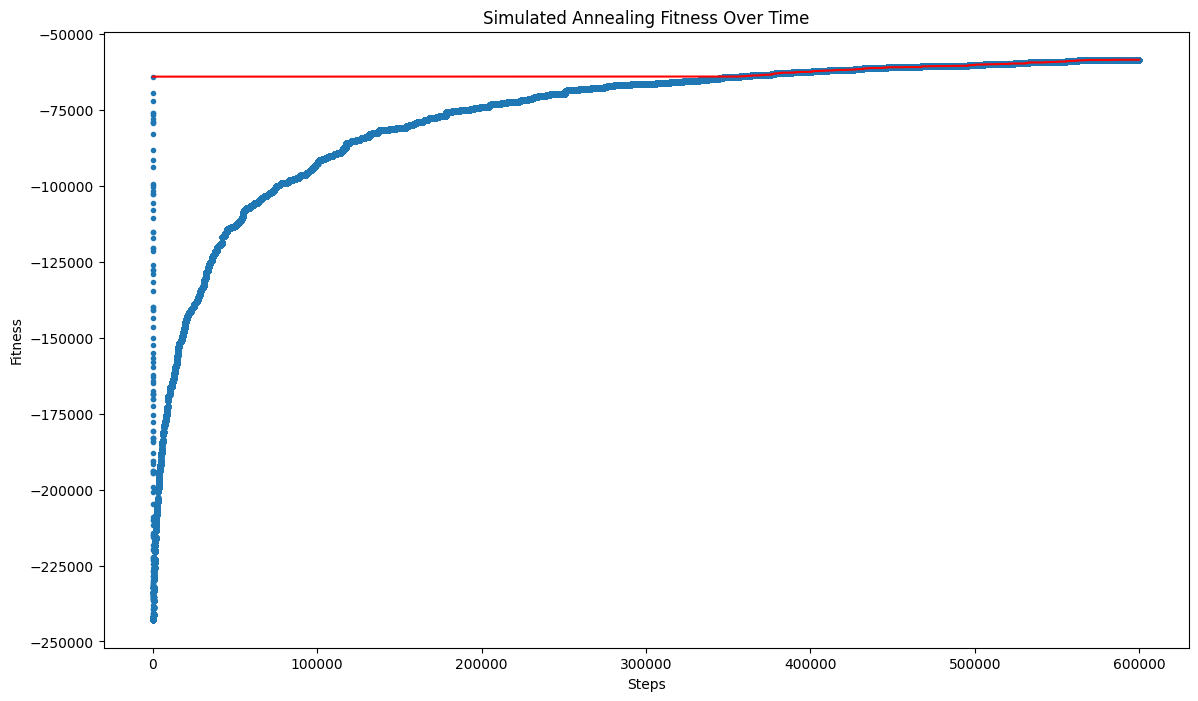

INFO:root:result: Found a path of 726 steps(cities), total length 58390.56km
DEBUG:root:step: Ancona -> Rimini (90.60km)
DEBUG:root:step: Rimini -> Forlì (46.72km)
DEBUG:root:step: Forlì -> Ravenna (26.46km)
DEBUG:root:step: Ravenna -> Ferrara (66.67km)
DEBUG:root:step: Ferrara -> Bologna (43.43km)
DEBUG:root:step: Bologna -> Modena (37.29km)
DEBUG:root:step: Modena -> Reggio nell'Emilia (23.94km)
DEBUG:root:step: Reggio nell'Emilia -> Parma (26.94km)
DEBUG:root:step: Parma -> Piacenza (57.65km)
DEBUG:root:step: Piacenza -> Milan (60.65km)
DEBUG:root:step: Milan -> Monza (14.51km)
DEBUG:root:step: Monza -> Bergamo (33.92km)
DEBUG:root:step: Bergamo -> Brescia (46.02km)
DEBUG:root:step: Brescia -> Verona (61.42km)
DEBUG:root:step: Verona -> Vicenza (44.70km)
DEBUG:root:step: Vicenza -> Padua (30.13km)
DEBUG:root:step: Padua -> Venice (36.07km)
DEBUG:root:step: Venice -> Trieste (115.09km)
DEBUG:root:step: Trieste -> Bolzano (209.68km)
DEBUG:root:step: Bolzano -> Trento (49.94km)
DEBUG:r

Fitness for China: (True, np.float64(-58390.55877230818))



DEBUG:root:step: Palermo -> Cagliari (390.28km)
DEBUG:root:step: Cagliari -> Sassari (173.89km)
DEBUG:root:step: Sassari -> Pescara (508.61km)
DEBUG:root:step: Pescara -> Ancona (139.24km)
INFO:root:result: Found a path of 46 steps, total length 4436.03km


Initial fitness: (True, np.float64(-4436.03176952516))


DEBUG:root:step: Ancona -> Rimini (90.60km)
DEBUG:root:step: Rimini -> Forlì (46.72km)
DEBUG:root:step: Forlì -> Ravenna (26.46km)
DEBUG:root:step: Ravenna -> Ferrara (66.67km)
DEBUG:root:step: Ferrara -> Bologna (43.43km)
DEBUG:root:step: Bologna -> Modena (37.29km)
DEBUG:root:step: Modena -> Reggio nell'Emilia (23.94km)
DEBUG:root:step: Reggio nell'Emilia -> Parma (26.94km)
DEBUG:root:step: Parma -> Piacenza (57.65km)
DEBUG:root:step: Piacenza -> Milan (60.65km)
DEBUG:root:step: Milan -> Monza (14.51km)
DEBUG:root:step: Monza -> Bergamo (33.92km)
DEBUG:root:step: Bergamo -> Brescia (46.02km)
DEBUG:root:step: Brescia -> Verona (61.42km)
DEBUG:root:step: Verona -> Vicenza (44.70km)
DEBUG:root:step: Vicenza -> Padua (30.13km)
DEBUG:root:step: Padua -> Venice (36.07km)
DEBUG:root:step: Venice -> Trieste (115.09km)
DEBUG:root:step: Trieste -> Bolzano (209.68km)
DEBUG:root:step: Bolzano -> Trento (49.94km)
DEBUG:root:step: Trento -> Novara (206.69km)
DEBUG:root:step: Novara -> Turin (84.46

Restarting from a new random solution...


DEBUG:root:step: Ancona -> Rimini (90.60km)
DEBUG:root:step: Rimini -> Forlì (46.72km)
DEBUG:root:step: Forlì -> Ravenna (26.46km)
DEBUG:root:step: Ravenna -> Ferrara (66.67km)
DEBUG:root:step: Ferrara -> Bologna (43.43km)
DEBUG:root:step: Bologna -> Modena (37.29km)
DEBUG:root:step: Modena -> Reggio nell'Emilia (23.94km)
DEBUG:root:step: Reggio nell'Emilia -> Parma (26.94km)
DEBUG:root:step: Parma -> Piacenza (57.65km)
DEBUG:root:step: Piacenza -> Milan (60.65km)
DEBUG:root:step: Milan -> Monza (14.51km)
DEBUG:root:step: Monza -> Bergamo (33.92km)
DEBUG:root:step: Bergamo -> Brescia (46.02km)
DEBUG:root:step: Brescia -> Verona (61.42km)
DEBUG:root:step: Verona -> Vicenza (44.70km)
DEBUG:root:step: Vicenza -> Padua (30.13km)
DEBUG:root:step: Padua -> Venice (36.07km)
DEBUG:root:step: Venice -> Trieste (115.09km)
DEBUG:root:step: Trieste -> Bolzano (209.68km)
DEBUG:root:step: Bolzano -> Trento (49.94km)
DEBUG:root:step: Trento -> Novara (206.69km)
DEBUG:root:step: Novara -> Turin (84.46

Restarting from a new random solution...


DEBUG:root:step: Ancona -> Rimini (90.60km)
DEBUG:root:step: Rimini -> Forlì (46.72km)
DEBUG:root:step: Forlì -> Ravenna (26.46km)
DEBUG:root:step: Ravenna -> Ferrara (66.67km)
DEBUG:root:step: Ferrara -> Bologna (43.43km)
DEBUG:root:step: Bologna -> Modena (37.29km)
DEBUG:root:step: Modena -> Reggio nell'Emilia (23.94km)
DEBUG:root:step: Reggio nell'Emilia -> Parma (26.94km)
DEBUG:root:step: Parma -> Piacenza (57.65km)
DEBUG:root:step: Piacenza -> Milan (60.65km)
DEBUG:root:step: Milan -> Monza (14.51km)
DEBUG:root:step: Monza -> Bergamo (33.92km)
DEBUG:root:step: Bergamo -> Brescia (46.02km)
DEBUG:root:step: Brescia -> Verona (61.42km)
DEBUG:root:step: Verona -> Vicenza (44.70km)
DEBUG:root:step: Vicenza -> Padua (30.13km)
DEBUG:root:step: Padua -> Venice (36.07km)
DEBUG:root:step: Venice -> Trieste (115.09km)
DEBUG:root:step: Trieste -> Bolzano (209.68km)
DEBUG:root:step: Bolzano -> Trento (49.94km)
DEBUG:root:step: Trento -> Novara (206.69km)
DEBUG:root:step: Novara -> Turin (84.46

Restarting from a new random solution...


DEBUG:root:step: Ancona -> Rimini (90.60km)
DEBUG:root:step: Rimini -> Forlì (46.72km)
DEBUG:root:step: Forlì -> Ravenna (26.46km)
DEBUG:root:step: Ravenna -> Ferrara (66.67km)
DEBUG:root:step: Ferrara -> Bologna (43.43km)
DEBUG:root:step: Bologna -> Modena (37.29km)
DEBUG:root:step: Modena -> Reggio nell'Emilia (23.94km)
DEBUG:root:step: Reggio nell'Emilia -> Parma (26.94km)
DEBUG:root:step: Parma -> Piacenza (57.65km)
DEBUG:root:step: Piacenza -> Milan (60.65km)
DEBUG:root:step: Milan -> Monza (14.51km)
DEBUG:root:step: Monza -> Bergamo (33.92km)
DEBUG:root:step: Bergamo -> Brescia (46.02km)
DEBUG:root:step: Brescia -> Verona (61.42km)
DEBUG:root:step: Verona -> Vicenza (44.70km)
DEBUG:root:step: Vicenza -> Padua (30.13km)
DEBUG:root:step: Padua -> Venice (36.07km)
DEBUG:root:step: Venice -> Trieste (115.09km)
DEBUG:root:step: Trieste -> Bolzano (209.68km)
DEBUG:root:step: Bolzano -> Trento (49.94km)
DEBUG:root:step: Trento -> Novara (206.69km)
DEBUG:root:step: Novara -> Turin (84.46

Restarting from a new random solution...
Best solution found: [27, 26, 39, 34, 15, 14, 21, 35, 11, 1, 2, 38, 17, 31, 37, 8, 24, 7, 36, 16, 10, 29, 13, 42, 22, 18, 20, 3, 40, 5, 41, 43, 23, 45, 44, 6, 28, 25, 32, 19, 4, 9, 30, 12, 33, 0, 27]
Best fitness: (True, np.float64(-4274.797108149282))
Result obtained during the iteration: 126981
Best cost:  4274.797108149282


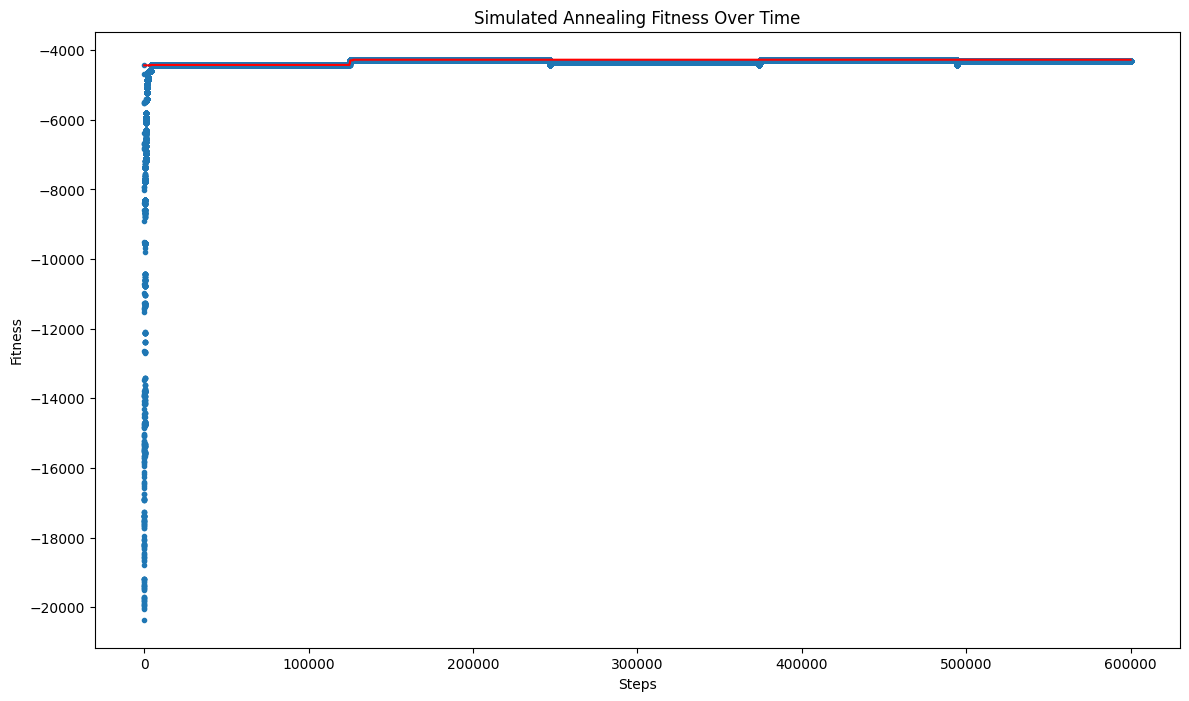

INFO:root:result: Found a path of 46 steps(cities), total length 4274.80km


Fitness for Italy: (True, np.float64(-4274.797108149282))



DEBUG:root:step: Abakan -> Krasnoyarsk (276.58km)
DEBUG:root:step: Krasnoyarsk -> Achinsk (161.71km)
DEBUG:root:step: Achinsk -> Kemerovo (296.59km)
DEBUG:root:step: Kemerovo -> Leninsk‐Kuznetskiy (74.76km)
DEBUG:root:step: Leninsk‐Kuznetskiy -> Prokopyevsk (91.87km)
DEBUG:root:step: Prokopyevsk -> Novokuznetsk (30.63km)
DEBUG:root:step: Novokuznetsk -> Biysk (187.38km)
DEBUG:root:step: Biysk -> Barnaul (132.82km)
DEBUG:root:step: Barnaul -> Novosibirsk (194.50km)
DEBUG:root:step: Novosibirsk -> Tomsk (206.90km)
DEBUG:root:step: Tomsk -> Seversk (14.97km)
DEBUG:root:step: Seversk -> Rubtsovsk (613.13km)
DEBUG:root:step: Rubtsovsk -> Omsk (647.47km)
DEBUG:root:step: Omsk -> Tobolsk (475.40km)
DEBUG:root:step: Tobolsk -> Tyumen (200.98km)
DEBUG:root:step: Tyumen -> Kurgan (189.69km)
DEBUG:root:step: Kurgan -> Kopeysk (236.87km)
DEBUG:root:step: Kopeysk -> Chelyabinsk (14.72km)
DEBUG:root:step: Chelyabinsk -> Miass (87.20km)
DEBUG:root:step: Miass -> Zlatoust (33.88km)
DEBUG:root:step: Zl

Initial fitness: (True, np.float64(-42334.16465744784))


DEBUG:root:step: Abakan -> Krasnoyarsk (276.58km)
DEBUG:root:step: Krasnoyarsk -> Achinsk (161.71km)
DEBUG:root:step: Achinsk -> Kemerovo (296.59km)
DEBUG:root:step: Kemerovo -> Leninsk‐Kuznetskiy (74.76km)
DEBUG:root:step: Leninsk‐Kuznetskiy -> Prokopyevsk (91.87km)
DEBUG:root:step: Prokopyevsk -> Novokuznetsk (30.63km)
DEBUG:root:step: Novokuznetsk -> Biysk (187.38km)
DEBUG:root:step: Biysk -> Barnaul (132.82km)
DEBUG:root:step: Barnaul -> Novosibirsk (194.50km)
DEBUG:root:step: Novosibirsk -> Tomsk (206.90km)
DEBUG:root:step: Tomsk -> Seversk (14.97km)
DEBUG:root:step: Seversk -> Rubtsovsk (613.13km)
DEBUG:root:step: Rubtsovsk -> Omsk (647.47km)
DEBUG:root:step: Omsk -> Tobolsk (475.40km)
DEBUG:root:step: Tobolsk -> Tyumen (200.98km)
DEBUG:root:step: Tyumen -> Kurgan (189.69km)
DEBUG:root:step: Kurgan -> Kopeysk (236.87km)
DEBUG:root:step: Kopeysk -> Chelyabinsk (14.72km)
DEBUG:root:step: Chelyabinsk -> Miass (87.20km)
DEBUG:root:step: Miass -> Zlatoust (33.88km)
DEBUG:root:step: Zl

Restarting from a new random solution...
Best solution found: [17, 3, 31, 144, 23, 16, 146, 6, 151, 71, 41, 48, 162, 106, 61, 157, 82, 92, 93, 78, 132, 75, 14, 133, 4, 123, 67, 107, 116, 47, 110, 34, 147, 148, 21, 154, 51, 32, 158, 115, 141, 121, 126, 10, 50, 69, 66, 43, 163, 95, 108, 122, 94, 127, 18, 56, 13, 135, 53, 88, 128, 64, 5, 130, 76, 22, 45, 111, 72, 149, 73, 30, 42, 63, 38, 24, 8, 28, 12, 112, 84, 89, 125, 152, 153, 155, 37, 29, 120, 9, 103, 119, 136, 59, 160, 156, 129, 102, 35, 140, 87, 114, 46, 165, 60, 164, 27, 81, 98, 150, 52, 68, 7, 26, 80, 19, 83, 161, 39, 25, 145, 134, 138, 85, 118, 117, 99, 100, 91, 101, 62, 131, 143, 96, 2, 77, 70, 74, 33, 44, 104, 79, 105, 159, 36, 166, 65, 20, 49, 55, 142, 137, 97, 113, 11, 15, 86, 109, 58, 90, 124, 139, 40, 1, 54, 0, 57, 17]
Best fitness: (True, np.float64(-34969.049207398915))
Result obtained during the iteration: 309805
Best cost:  34969.049207398915


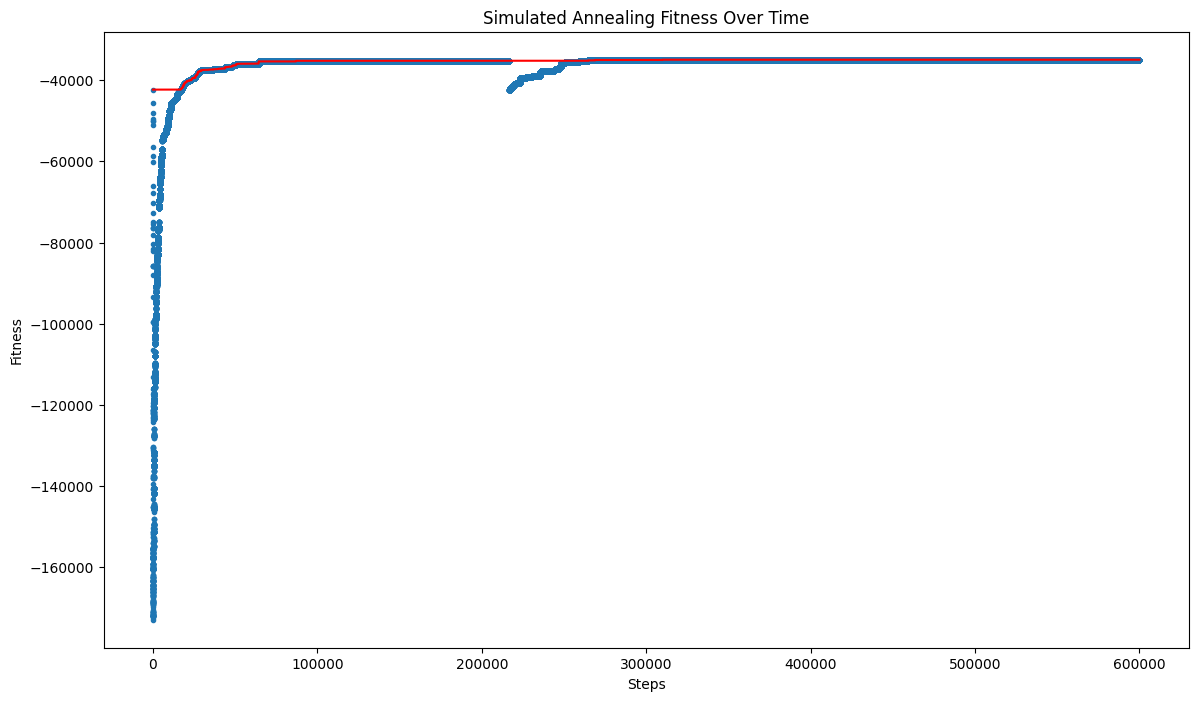

INFO:root:result: Found a path of 167 steps(cities), total length 34969.05km


Fitness for Russia: (True, np.float64(-34969.049207398915))



DEBUG:root:step: Abilene -> Wichita Falls (196.78km)
DEBUG:root:step: Wichita Falls -> Denton (149.68km)
DEBUG:root:step: Denton -> Lewisville (23.92km)
DEBUG:root:step: Lewisville -> Carrollton (10.02km)
DEBUG:root:step: Carrollton -> Plano (15.78km)
DEBUG:root:step: Plano -> Allen (9.27km)
DEBUG:root:step: Allen -> McKinney (10.45km)
DEBUG:root:step: McKinney -> Frisco (15.17km)
DEBUG:root:step: Frisco -> Richardson (22.38km)
DEBUG:root:step: Richardson -> Garland (10.04km)
DEBUG:root:step: Garland -> Mesquite (16.57km)
DEBUG:root:step: Mesquite -> Dallas (16.56km)
DEBUG:root:step: Dallas -> Irving (20.41km)
DEBUG:root:step: Irving -> Grand Prairie (19.83km)
DEBUG:root:step: Grand Prairie -> Fort Worth (32.28km)
DEBUG:root:step: Fort Worth -> Waco (136.07km)
DEBUG:root:step: Waco -> Killeen (74.58km)
DEBUG:root:step: Killeen -> Round Rock (61.72km)
DEBUG:root:step: Round Rock -> Austin (25.47km)
DEBUG:root:step: Austin -> San Antonio (118.67km)
DEBUG:root:step: San Antonio -> Corpus 

Initial fitness: (True, np.float64(-48050.02586446137))


KeyboardInterrupt: 

In [ ]:
max_steps = 1000000

for country_name, file_path in country_files.items():
    
    CITIES, DIST_MATRIX = load_city_data(file_path)
    initial_solution = greedy_tsp_initialization(CITIES, DIST_MATRIX)
    optimized_route, optimized_fitness, optimized_cost = simulated_annealing(initial_solution, max_steps, CITIES, DIST_MATRIX)
    print(f"Fitness for {country_name}: {optimized_fitness}")
    logging.info(f"result: Found a path of {len(optimized_route)-1} steps(cities), total length {optimized_cost:.2f}km")
    print()
